In [ ]:
#basic operations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

#trajectory smoothening
from scipy.interpolate import splprep, splev

#deep learning
import torch
import torch.nn as nn
from complexPyTorch.complexLayers import ComplexLinear, ComplexReLU
from torch.utils.data import TensorDataset, DataLoader, random_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
import torch

# Total number of GPUs available
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# List all GPU names
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# Optional: check if CUDA is available
print("Is CUDA available?", torch.cuda.is_available())


Number of GPUs available: 8
GPU 0: NVIDIA H100 80GB HBM3
GPU 1: NVIDIA H100 80GB HBM3
GPU 2: NVIDIA H100 80GB HBM3
GPU 3: NVIDIA H100 80GB HBM3
GPU 4: NVIDIA H100 80GB HBM3
GPU 5: NVIDIA H100 80GB HBM3
GPU 6: NVIDIA H100 80GB HBM3
GPU 7: NVIDIA H100 80GB HBM3
Is CUDA available? True


In [4]:
# Environment Parameters
epsilon = 1e-10
seed = 42


grid_min, grid_max = 0, 1
step_size = 0.1 # epsilon # distance after which angle changes.
total_time = 10
lookahead = 2
velocity = np.random.uniform(1, 5)
total_distance = velocity * total_time
num_steps = np.floor(total_distance / step_size)
rng = np.random.default_rng()

#x_initial, y_initial = np.random.uniform(grid_min, grid_max, size=2)
#head_dir_initial = math.radians(30)
#print(x_initial, y_initial)

tier_1 = np.arange(-30, 30, 1)
tier_2 = list(range(-60, -30)) + list(range(30, 60))
tier_3 = list(range(-90, -60)) + list(range(60, 90))
num_tries = 10


In [5]:
def get_future_pos(x_current, y_current, head_dir_current):
  x_future = x_current + lookahead * step_size * math.cos(head_dir_current)
  y_future = y_current + lookahead * step_size * math.sin(head_dir_current)
  return x_future, y_future

In [6]:
# Tiered search (random within tiers)
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi


def choose_head_dir(x_current, y_current, head_dir_current):
  for _ in range(num_tries):
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_1)))
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min < x_future < grid_max and grid_min < y_future < grid_max:
      #print("Turning slightly")
      return x_future, y_future, head_dir_next

  for _ in range(num_tries):  
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_2)))    
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min < x_future < grid_max and grid_min < y_future < grid_max:
      #print("Turning diagonally")
      return x_future, y_future, head_dir_next
  
  for _ in range(num_tries):
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_3)))
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min <= x_future <= grid_max and grid_min < y_future < grid_max:
      #print("Turning almost orthagonally")
      return x_future, y_future, head_dir_next
    
  head_dir_next = wrap_angle(head_dir_current + math.radians(180))
  x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
  #print("Taking a U-turn")
  return x_future, y_future, head_dir_next

In [7]:
# Trajectory generation

def generate_trajectory(velocity):
    x_sharp = []
    y_sharp = []
    head_dir = []
    x_initial, y_initial = np.random.uniform(grid_min, grid_max, size=2)
    initial_positions = (x_initial, y_initial)
    head_dir_initial = math.radians(0)
    distance = velocity * total_time
    num_steps = np.floor(distance / step_size)

    for i in range(int(num_steps)):
        if i == 0:
            head_dir_current = head_dir_initial
            x_current, y_current = x_initial, y_initial
            x_sharp.append(x_current)
            y_sharp.append(y_current)
            head_dir.append(head_dir_current)
        
        x_future, y_future, head_dir_next = choose_head_dir(x_current, y_current, head_dir_current)
        x_next = x_current + step_size * math.cos(head_dir_next)
        y_next = y_current + step_size * math.sin(head_dir_next)
        
        head_dir_current = head_dir_next
        x_current, y_current = x_next, y_next

        x_sharp.append(x_current)
        y_sharp.append(y_current)
        head_dir.append(head_dir_current)


    x_sharp = np.array(x_sharp)
    y_sharp = np.array(y_sharp)
    head_dir = np.array(head_dir)
    initial_positions = np.array(initial_positions)
    #print(X.shape, Y.shape, HD.shape, initial_positions.shape)    
    return initial_positions, x_sharp, y_sharp    


In [8]:
# Using Spline function
def generate_smooth_trajectory(velocity):

    initial_positions, x_sharp, y_sharp = generate_trajectory(velocity)
    # s = smoothing factor, larger = smoother
    tck, u = splprep([x_sharp, y_sharp], s=0)
    u_new = np.linspace(0, 1, 1000)  # denser sampling
    x_smooth, y_smooth = splev(u_new, tck)
    return initial_positions, x_smooth, y_smooth

In [9]:
def compute_heading_vectors(x_smooth, y_smooth):
    cos_thetas, sin_thetas = [], []
    for i in range(len(x_smooth)-1):
        dx = x_smooth[i+1] - x_smooth[i]
        dy = y_smooth[i+1] - y_smooth[i]
        #heading_angle = math.atan2(dy, dx)
        norm = np.sqrt(dx**2 + dy**2) + 1e-8
        cos_theta = dx / norm
        sin_theta = dy / norm
        cos_thetas.append(cos_theta)
        sin_thetas.append(sin_theta)
    cos_thetas.append(cos_thetas[-1])  # Repeat last vector to maintain length
    sin_thetas.append(sin_thetas[-1])  # Repeat last vector to maintain length
    return cos_thetas, sin_thetas

In [10]:
def compute_abs_heading_vectors(x_smooth, y_smooth):
    cos_thetas, sin_thetas = [], []
    for i in range(len(x_smooth)):
        norm = np.sqrt(x_smooth[i]**2 + y_smooth[i]**2) + 1e-8
        cos_theta = x_smooth[i] / norm
        sin_theta = y_smooth[i] / norm
        cos_thetas.append(cos_theta)
        sin_thetas.append(sin_theta)
    return cos_thetas, sin_thetas

In [11]:
# Limb oscillations with curvature

#Parameters

dt = 0.01 # time step
time_series = np.arange(0, total_time, dt)
total_time_steps = len(time_series)

am = 0.1 # stride length
L = 0.05 # length of limb
phi = math.pi #phase difference between contralateral limbs
d = 0.05 # spacing between limb pairs

theta_m = am / (4 * L) # max angle of limb movement
limb_osc_freq = rng.uniform(1, 5) # frequency of limb oscillation
omega = 2 * math.pi * limb_osc_freq # angular frequency

def curvature(x, y):
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    return (dx * ddy - dy * ddx) / ((dx**2 + dy**2)**1.5 + 1e-8)
    # To avoid division by zero

def limb_oscillations_with_curvature(t, am, L, omega, phi, d, x, y):
    theta_m = am / (4 * L)
    k = curvature(x, y)

    UFL = theta_m * (1 + k*d) * np.sin(omega*t)
    UFR = theta_m * (1 - k*d) * np.sin(omega*t + phi)
    UHR = theta_m * (1 - k*d) * np.sin(omega*t)
    UHL = theta_m * (1 + k*d) * np.sin(omega*t + phi)

    return UFL, UFR, UHR, UHL, k

In [12]:
# Generate 100 trajectories and corresponding limb oscillations

def generate_data(num_trajectories):
    x_smooth_all, y_smooth_all = [], []
    limb_data_all = []
    initial_positions_all = []
    cos_thetas_all, sin_thetas_all = [], []

    for trajectory in range(num_trajectories):
        limb_osc_freq = np.random.uniform(1, 5)
        velocity = am * limb_osc_freq
        omega = 2 * math.pi * limb_osc_freq #angular frequency
        
        initial_positions, x_smooth, y_smooth = generate_smooth_trajectory(velocity)
        cos_thetas, sin_thetas = compute_heading_vectors(x_smooth, y_smooth)
        limb_data = limb_oscillations_with_curvature(time_series, am, L, omega, phi, d, x_smooth, y_smooth)
        
        initial_positions_all.append(initial_positions)
        x_smooth_all.append(x_smooth)
        y_smooth_all.append(y_smooth)
        cos_thetas_all.append(cos_thetas)
        sin_thetas_all.append(sin_thetas)
        limb_data_all.append(limb_data)


    return initial_positions_all, x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all, limb_data_all
    print("Generated", num_trajectories, "trajectories with corresponding limb oscillations.")

initial_positions_all, x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all, limb_data_all = generate_data(100)


In [13]:
initial_positions_all = np.array(initial_positions_all)
x_smooth_all = np.array(x_smooth_all)
y_smooth_all = np.array(y_smooth_all)
limb_data_all = np.array(limb_data_all)
cos_thetas_all = np.array(cos_thetas_all)
sin_thetas_all = np.array(sin_thetas_all)

print(initial_positions_all.shape, x_smooth_all.shape, y_smooth_all.shape, cos_thetas_all.shape, sin_thetas_all.shape, limb_data_all.shape)

(100, 2) (100, 1000) (100, 1000) (100, 1000) (100, 1000) (100, 5, 1000)


In [14]:
traj_data = np.stack((x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all), axis=-1)
traj_data = np.array(traj_data)
print(traj_data.shape) # (100, 1000, 2)

gait_data = limb_data_all.transpose(0, 2, 1)  # (num_trajectories, time_steps, 4 limbs + curvature)
print(gait_data.shape) # (100, 1000, 5)
gait_data_without_curvature = gait_data[:, :, :4]
print(gait_data_without_curvature.shape) #(100, 1000, 4)

initial_positions_all_expanded = np.repeat(initial_positions_all[:, :, np.newaxis], 1000, axis=2)
print(initial_positions_all_expanded.shape)  # (100, 2, 1000)
initial_positions_transpose = initial_positions_all_expanded.transpose(0, 2, 1)
print(initial_positions_transpose.shape)  # (100, 1000, 2)

gait_data_with_initial_pos = np.concatenate((initial_positions_transpose, gait_data_without_curvature), axis=2)
print(gait_data_with_initial_pos.shape) # (100, 1000, 6)

(100, 1000, 4)
(100, 1000, 5)
(100, 1000, 4)
(100, 2, 1000)
(100, 1000, 2)
(100, 1000, 6)


In [15]:
X = gait_data_with_initial_pos
Y = {'pos': traj_data[:, :, :2], 'hd': traj_data[:, :, 2:]}

print(X.shape, len(Y), Y['pos'].shape, Y['hd'].shape)

(100, 1000, 6) 2 (100, 1000, 2) (100, 1000, 2)


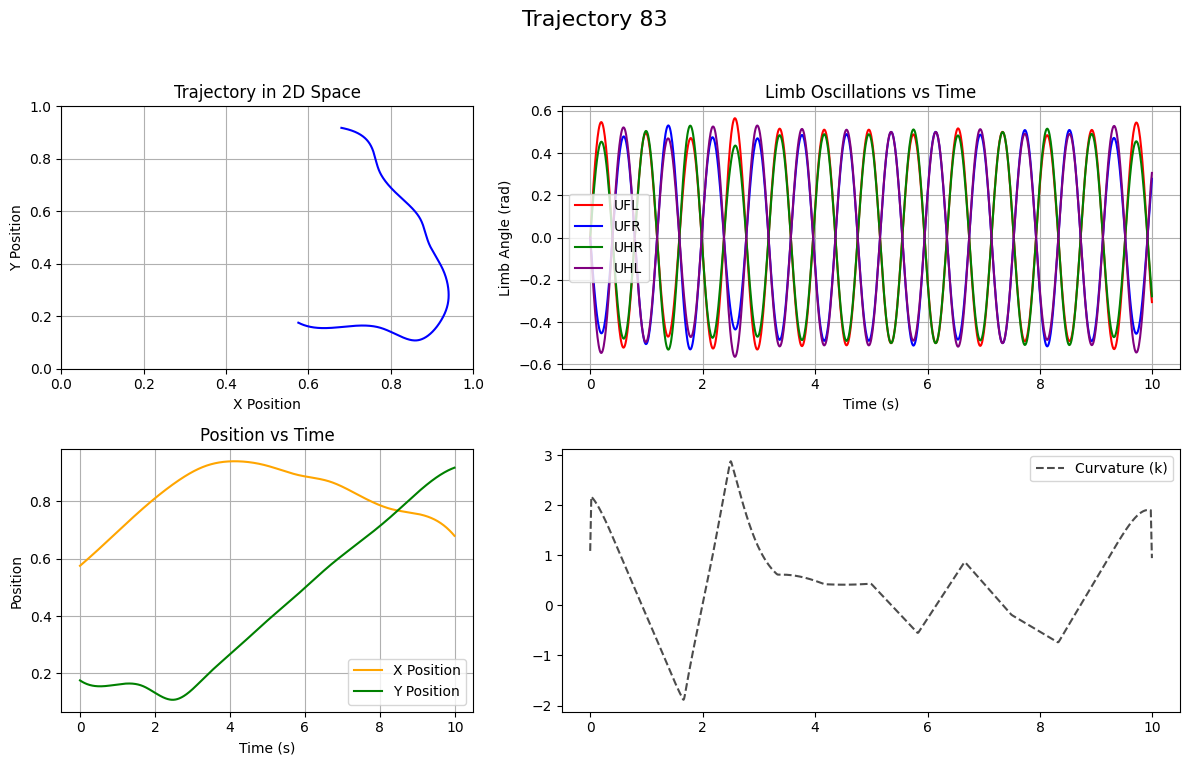

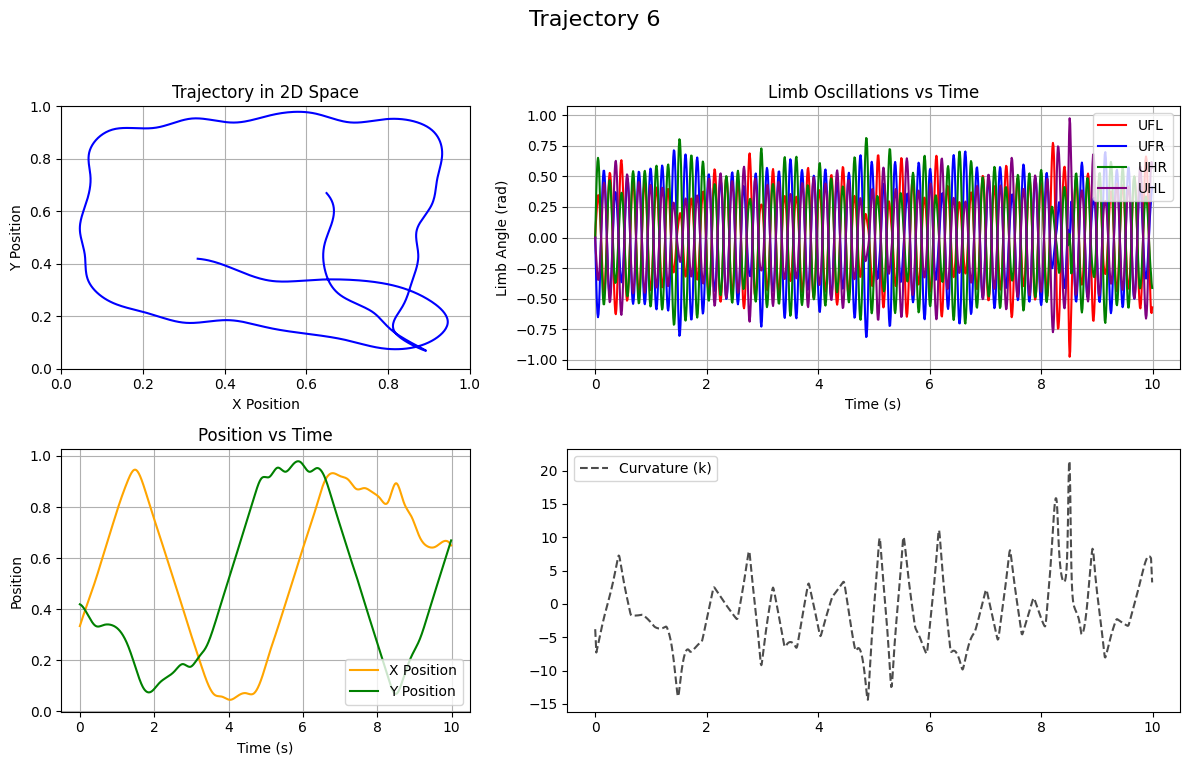

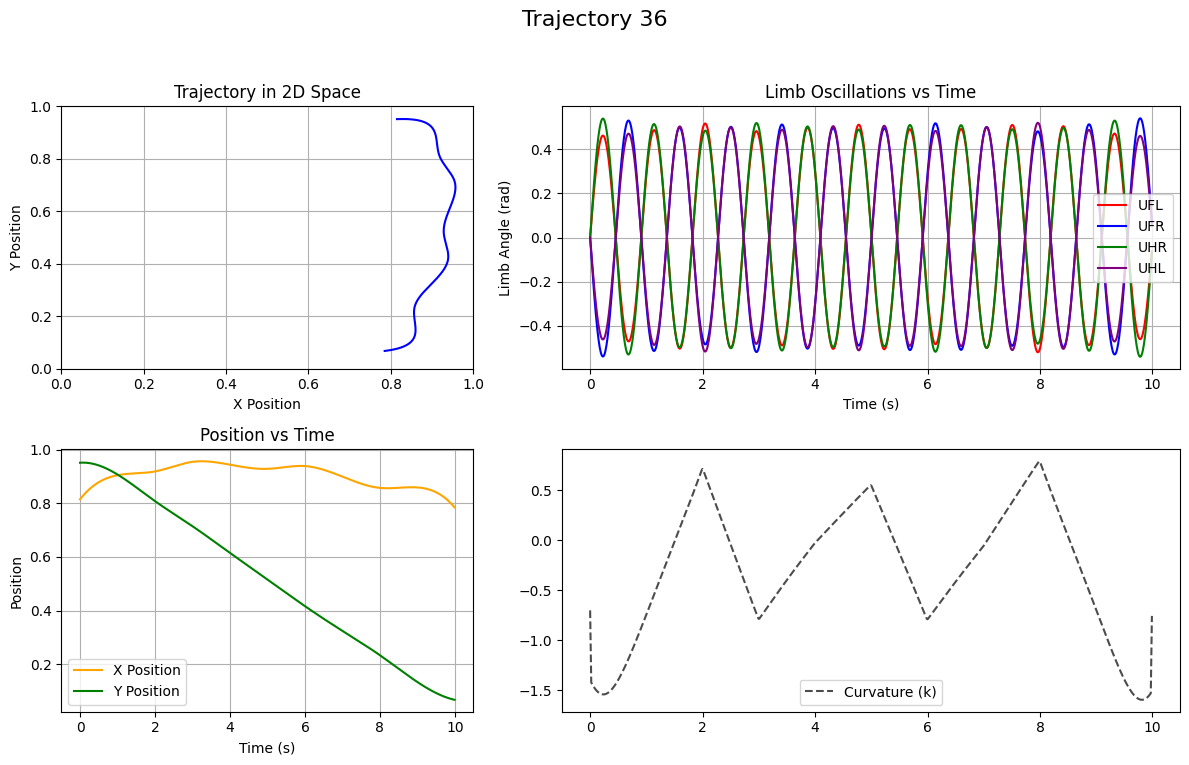

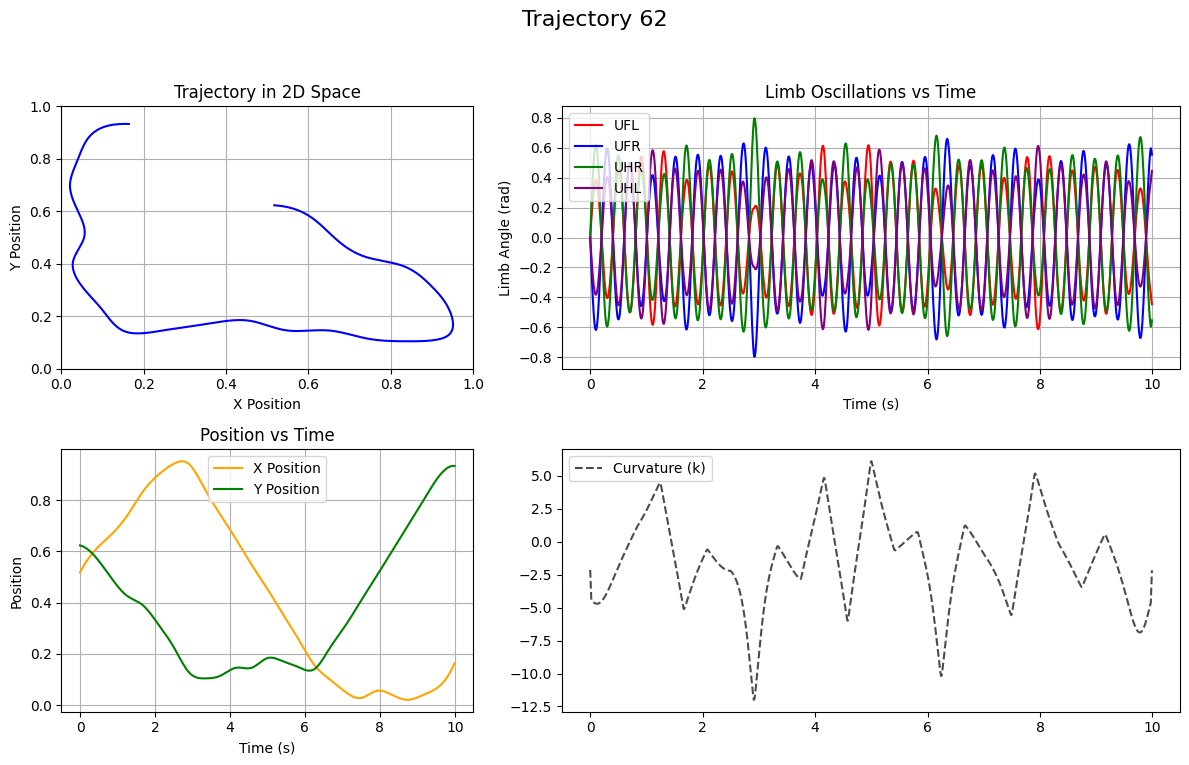

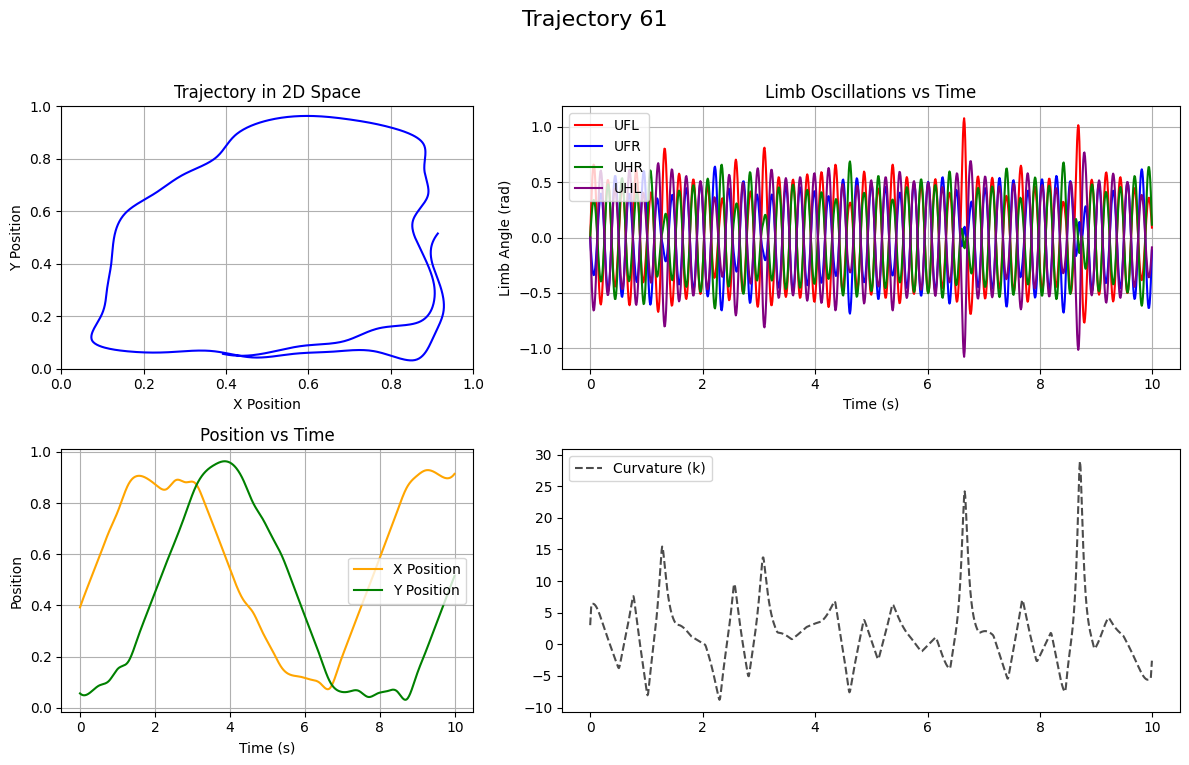

In [16]:
# Plotting trajectory, position vs time and limb oscillations for five random trajectories
for i in range(5):
    traj_index = np.random.randint(0, 100)
    x_traj = x_smooth_all[traj_index]
    y_traj = y_smooth_all[traj_index]
    limb_data_traj = limb_data_all[traj_index]
    UFL_traj, UFR_traj, UHR_traj, UHL_traj, k_traj = limb_data_traj

    # Time vector
    t = time_series[:len(x_traj)]

    # Create a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5]})
    fig.suptitle(f"Trajectory {traj_index+1}", fontsize=16)

    # --- Top-left: Trajectory in grid ---
    axes[0, 0].plot(x_traj, y_traj, color='blue')
    axes[0, 0].set_title('Trajectory in 2D Space')
    axes[0, 0].set_xlabel('X Position')
    axes[0, 0].set_ylabel('Y Position')
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid()

    # --- Bottom-left: Position vs time ---
    axes[1, 0].plot(t, x_traj, label='X Position', color='orange')
    axes[1, 0].plot(t, y_traj, label='Y Position', color='green')
    #axes[1, 0].plot(t, head_direction_traj[:len(t)], label='Head Direction', color='purple', linestyle='--', alpha=0.7)
    axes[1, 0].set_title('Position vs Time')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Position')
    axes[1, 0].legend()
    axes[1, 0].grid()

    # --- Right column (span): Limb oscillations ---
    ax_right = axes[0, 1]
    #axes[1, 1].remove()  # merge bottom cell with top
    ax_right.plot(t, UFL_traj[:len(t)], label='UFL', color='red')
    ax_right.plot(t, UFR_traj[:len(t)], label='UFR', color='blue')
    ax_right.plot(t, UHR_traj[:len(t)], label='UHR', color='green')
    ax_right.plot(t, UHL_traj[:len(t)], label='UHL', color='purple')
    ax_right.set_title('Limb Oscillations vs Time')
    ax_right.set_xlabel('Time (s)')
    ax_right.set_ylabel('Limb Angle (rad)')
    ax_right.legend()
    ax_right.grid()

    #Plotting k values
    ax_bottom_right = axes[1, 1]
    
    ax_bottom_right.plot(t, k_traj[:len(t)], label='Curvature (k)', color='black', linestyle='--', alpha=0.7)
    #ax_bottom_right.set_ylim(-30, 30)
    ax_bottom_right.legend()
    #ax_bottom_right.set_ylabel('Curvature (k)')
    #ax_k.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [17]:
#Hopf Oscillator

def real_cal(r, phi):
    return r * torch.cos(phi)

def imag_cal(r, phi):
    return r * torch.sin(phi)


def oscillator_loop(X_r, X_i, omegas, num_steps, dt=0.01, input_scaler=10.0):
    """
    X_r, X_i: real and imaginary parts of input signal [batch, time, units]
    omegas: angular frequencies of oscillators [1, units]
    num_steps: number of time steps
    """

    batch_size, _, units = X_r.shape
    r_t = torch.ones((batch_size, units), device=X_r.device)
    phis = torch.zeros((batch_size, units), device=X_r.device)

    r_list, phi_list = [], []

    for t in range(num_steps):
        # input at current time step
        input_r = input_scaler * X_r[:, t, :] * torch.cos(phis)
        input_phi = input_scaler * X_i[:, t, :] * torch.sin(phis)

        # Hopf oscillator update equations
        r_t = r_t + ((1 - r_t**2) * r_t + input_r) * dt
        phis = phis + (omegas - input_phi) * dt

        r_list.append(r_t.unsqueeze(1))   # keep time dimension
        phi_list.append(phis.unsqueeze(1))

    # Stack time axis -> shape [batch, time, units]
    r_arr = torch.cat(r_list, dim=1)
    phi_arr = torch.cat(phi_list, dim=1)
    return r_arr, phi_arr


# ------------------------------------------------------------
# Hopf Oscillator Module
# ------------------------------------------------------------
class Hopf(nn.Module):
    def __init__(self, units, num_steps, min_f=0.1, max_f=10.1):
        super(Hopf, self).__init__()
        self.units = units
        self.num_steps = num_steps

        # Frequencies equally spaced between min_f and max_f
        omegas = torch.linspace(min_f, max_f, units) * (2 * math.pi)
        self.register_buffer('omegas', omegas.unsqueeze(0))  # [1, units]

    def forward(self, z_complex):
        """
        z_complex: complex input tensor [batch, time, units]
        """
        X_r = z_complex.real
        X_i = z_complex.imag

        r, phi = oscillator_loop(X_r, X_i, self.omegas, self.num_steps)

        z_real = real_cal(r, phi)
        z_imag = imag_cal(r, phi)
        return torch.complex(z_real, z_imag)


In [18]:

class DONN(nn.Module):
    def __init__(self, units, duration):
        super(DONN, self).__init__()

        # -----------------------------
        # Complex Dense + Hopf layers
        # -----------------------------
        self.d1 = nn.Sequential(
            ComplexLinear(X.shape[-1], units),
            ComplexReLU()
        )
        self.osc1 = Hopf(units, num_steps=duration, min_f=1, max_f=5)

        self.d2 = nn.Sequential(
            ComplexLinear(units, units),
            ComplexReLU()
        )
        self.osc2 = Hopf(units, num_steps=duration, min_f=4, max_f=8)

        self.d3 = nn.Sequential(
            ComplexLinear(units, units),
            ComplexReLU()
        )
        self.osc3 = Hopf(units, num_steps=duration, min_f=8, max_f=10)

        self.d4 = nn.Sequential(
            ComplexLinear(units, units),
            ComplexReLU()
        )

        # -----------------------------
        # Real-valued output heads
        # -----------------------------
        self.pos_out = nn.Sequential(
            nn.Linear(units * 2, 2),  # for (x, y)
            nn.Sigmoid()
        )

        self.hd_out = nn.Sequential(
            nn.Linear(units * 2, 2),  # for (cosθ, sinθ)
            nn.Tanh()
        )

    def forward(self, X):
        """
        X: [batch, time, units] real input signal
        """

        # Convert to complex
        X_c = torch.complex(X, torch.zeros_like(X))

        # Sequential complex transformations + Hopf oscillations
        d1 = self.d1(X_c)
        z1 = self.osc1(d1)

        d2 = self.d2(z1)
        z2 = self.osc2(d2)

        d3 = self.d3(z2)
        z3 = self.osc3(d3)

        d4 = self.d4(z3)

        # Concatenate real + imag for output layers
        d4_concat = torch.cat([d4.real, d4.imag], dim=-1)

        # Position output (sigmoid) → (x, y)
        pos_out = self.pos_out(d4_concat)

        # Head direction output (tanh) → (cosθ, sinθ)
        hd_out = self.hd_out(d4_concat)
        hd_norm = hd_out / (torch.norm(hd_out, dim=-1, keepdim=True) + 1e-8)

        return {"pos": pos_out, "hd": hd_norm}


In [19]:

def custom_hd_loss(hd_true, hd_pred, alpha=1.0, beta=0.5):
    """
    Custom head-direction loss combining cosine similarity + circular penalty.
    """
    # Normalize both true and predicted vectors
    hd_true = hd_true / (torch.norm(hd_true, dim=-1, keepdim=True) + 1e-8)
    hd_pred = hd_pred / (torch.norm(hd_pred, dim=-1, keepdim=True) + 1e-8)

    # Cosine similarity loss
    cos_sim = torch.sum(hd_true * hd_pred, dim=-1)
    cos_sim_loss = 1.0 - torch.mean(cos_sim)

    # Circle penalty: (cos^2 + sin^2 - 1)^2
    circle_loss = torch.mean((torch.sum(hd_pred ** 2, dim=-1) - 1.0) ** 2)

    return alpha * cos_sim_loss + beta * circle_loss


In [22]:

# Hyperparameters
units = 100
learning_rate = 0.001
batch_size = 20

duration = total_time_steps  # same as in TF version

# Initialize model
model = DONN(units=units, duration=duration)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and loss functions
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
mse_loss = nn.MSELoss()


In [23]:
# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_pos_tensor = torch.tensor(Y["pos"], dtype=torch.float32)
Y_hd_tensor = torch.tensor(Y["hd"], dtype=torch.float32)

# Combine into one dataset
dataset = TensorDataset(X_tensor, Y_pos_tensor, Y_hd_tensor)

# 80-20 train-validation split
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [ ]:
def training_loop(start_epochs, end_epochs):
    for epoch in range(start_epochs, end_epochs):
        model.train()
        total_loss = 0.0
        
        for X_batch, Y_pos_batch, Y_hd_batch in train_loader:
            X_batch, Y_pos_batch, Y_hd_batch = X_batch.to(device), Y_pos_batch.to(device), Y_hd_batch.to(device)

            optimizer.zero_grad()

            outputs = model(X_batch)
            pos_pred = outputs["pos"]
            hd_pred = outputs["hd"]

            # Compute combined loss
            loss_pos = mse_loss(pos_pred, Y_pos_batch)
            loss_hd = custom_hd_loss(Y_hd_batch, hd_pred)
            loss = loss_pos + loss_hd

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for X_val, Y_pos_val, Y_hd_val in val_loader:
                X_val, Y_pos_val, Y_hd_val = X_val.to(device), Y_pos_val.to(device), Y_hd_val.to(device)
                outputs = model(X_val)
                pos_pred = outputs["pos"]
                hd_pred = outputs["hd"]
                val_loss += (mse_loss(pos_pred, Y_pos_val) + custom_hd_loss(Y_hd_val, hd_pred)).item()

        print(f"Epoch [{epoch+1}/{end_epochs}] | Train Loss: {total_loss/len(train_loader):.6f} | Val Loss: {val_loss/len(val_loader):.6f}")

    return total_loss

In [25]:
start_epochs = 0
end_epochs = 300

model_loss = training_loop(start_epochs, end_epochs)

Epoch [1/300] | Train Loss: 1.085787 | Val Loss: 1.043329
Epoch [2/300] | Train Loss: 1.004522 | Val Loss: 1.010211
Epoch [3/300] | Train Loss: 0.949913 | Val Loss: 0.983134
Epoch [4/300] | Train Loss: 0.912611 | Val Loss: 0.956358
Epoch [5/300] | Train Loss: 0.868064 | Val Loss: 0.933950
Epoch [6/300] | Train Loss: 0.825709 | Val Loss: 0.912467
Epoch [7/300] | Train Loss: 0.786674 | Val Loss: 0.890440
Epoch [8/300] | Train Loss: 0.739218 | Val Loss: 0.879840
Epoch [9/300] | Train Loss: 0.680157 | Val Loss: 0.854111
Epoch [10/300] | Train Loss: 0.628892 | Val Loss: 0.825445
Epoch [11/300] | Train Loss: 0.579550 | Val Loss: 0.801943
Epoch [12/300] | Train Loss: 0.544335 | Val Loss: 0.782009
Epoch [13/300] | Train Loss: 0.500155 | Val Loss: 0.754618
Epoch [14/300] | Train Loss: 0.456413 | Val Loss: 0.743588
Epoch [15/300] | Train Loss: 0.420993 | Val Loss: 0.715183
Epoch [16/300] | Train Loss: 0.393989 | Val Loss: 0.701880
Epoch [17/300] | Train Loss: 0.363276 | Val Loss: 0.674258
Epoch 

In [ ]:
#torch.save(model.state_dict(), "2d_weights_v1.pth")

torch.save({
    'epoch': 300,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': model_loss,
}, "checkpoint_epoch300.pth")


In [ ]:
# Initialize model and optimizer again
model = DONN(units=100, duration=total_time_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Load checkpoint
checkpoint = torch.load("checkpoint_epoch300.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1  # resume from next epoch

model.to(device)


DONN(
  (d1): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=6, out_features=100, bias=True)
      (fc_i): Linear(in_features=6, out_features=100, bias=True)
    )
    (1): ComplexReLU()
  )
  (osc1): Hopf()
  (d2): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=100, out_features=100, bias=True)
      (fc_i): Linear(in_features=100, out_features=100, bias=True)
    )
    (1): ComplexReLU()
  )
  (osc2): Hopf()
  (d3): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=100, out_features=100, bias=True)
      (fc_i): Linear(in_features=100, out_features=100, bias=True)
    )
    (1): ComplexReLU()
  )
  (osc3): Hopf()
  (d4): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=100, out_features=100, bias=True)
      (fc_i): Linear(in_features=100, out_features=100, bias=True)
    )
    (1): ComplexReLU()
  )
  (pos_out): Sequential(
    (0): Linear(in_features=200, out_features=2, bias=True)
    (1): Sigmoid()

In [29]:
with torch.no_grad():
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    predictions = model(X_tensor)
    pos_pred = predictions['pos'].cpu().numpy()
    hd_pred = predictions['hd'].cpu().numpy()

In [30]:
print(pos_pred.shape, hd_pred.shape)

(100, 1000, 2) (100, 1000, 2)


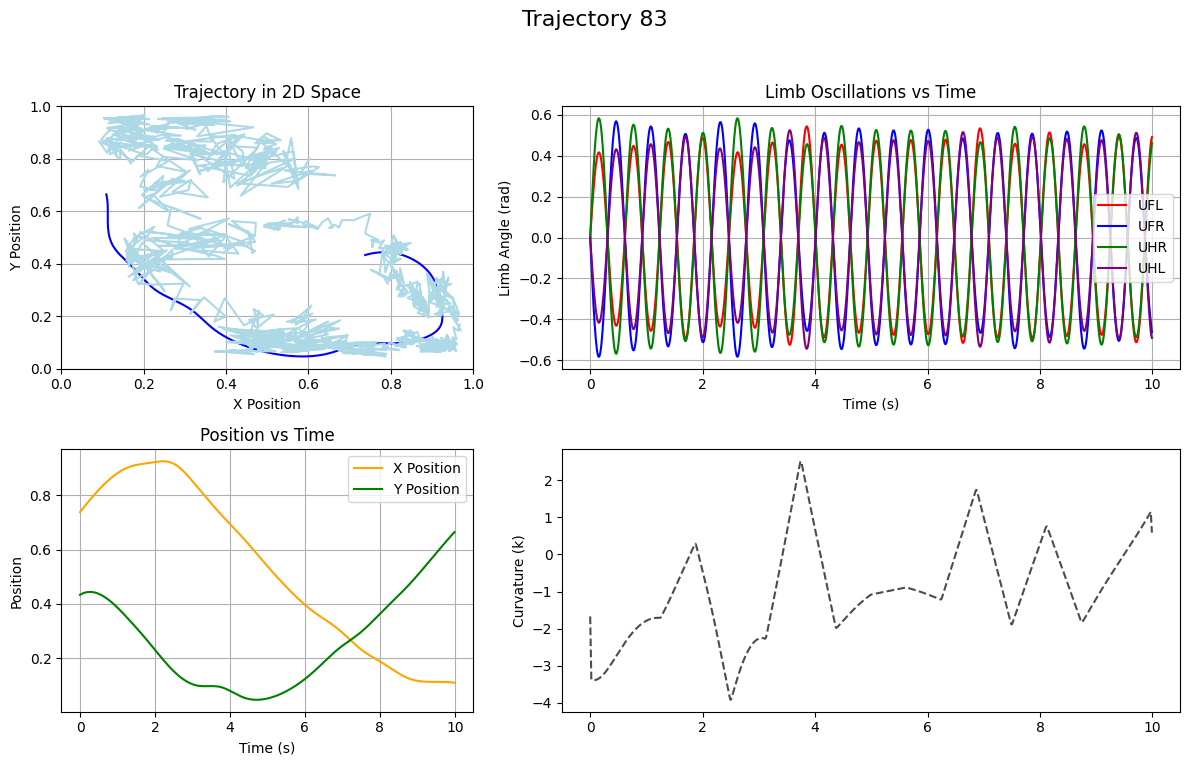

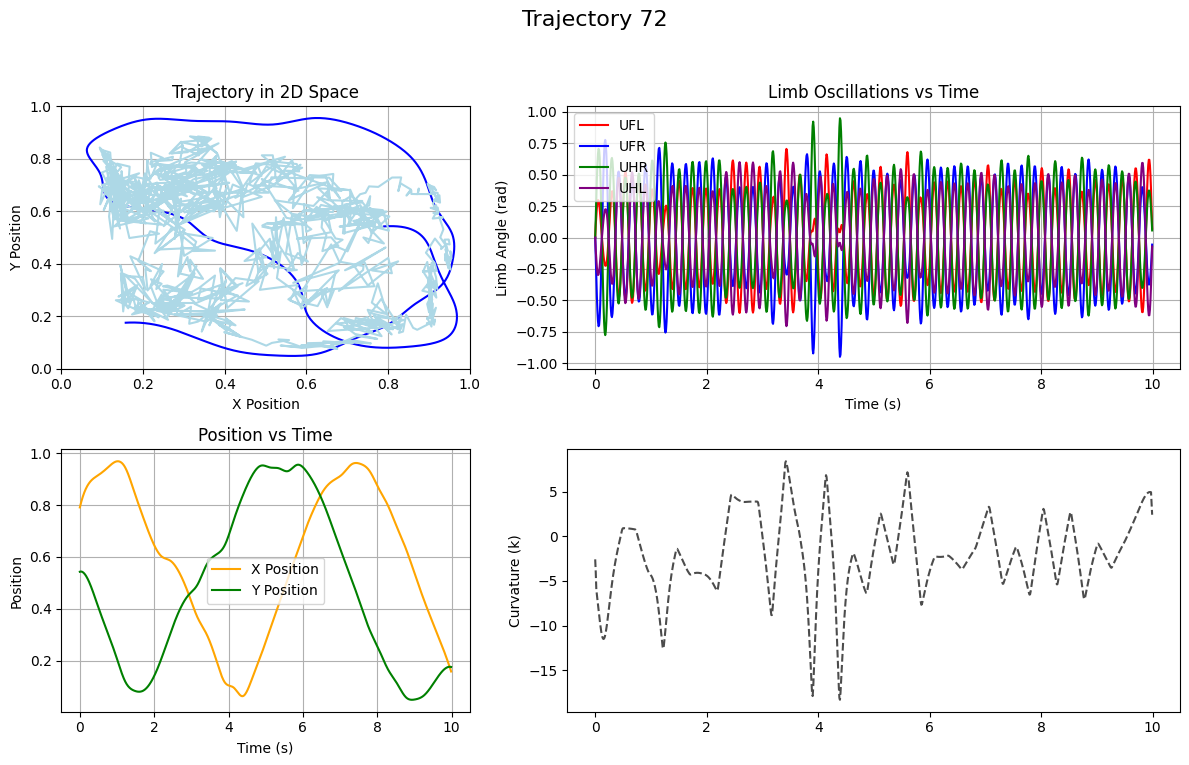

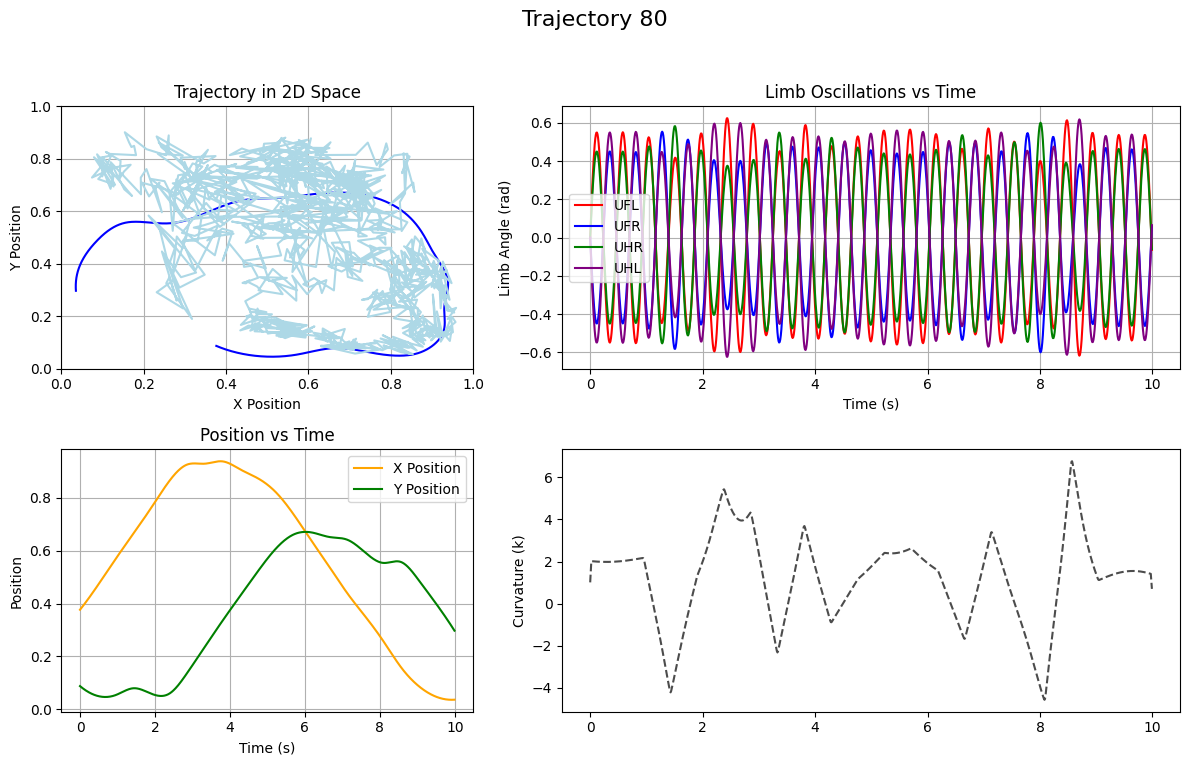

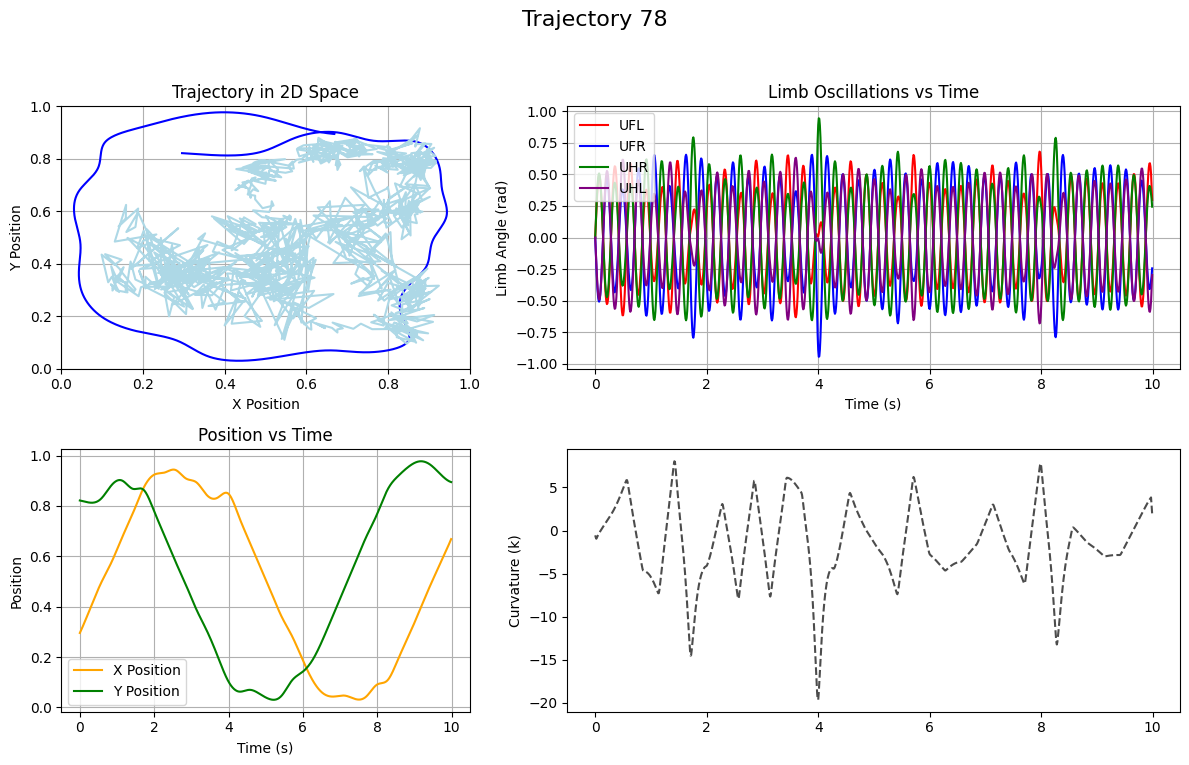

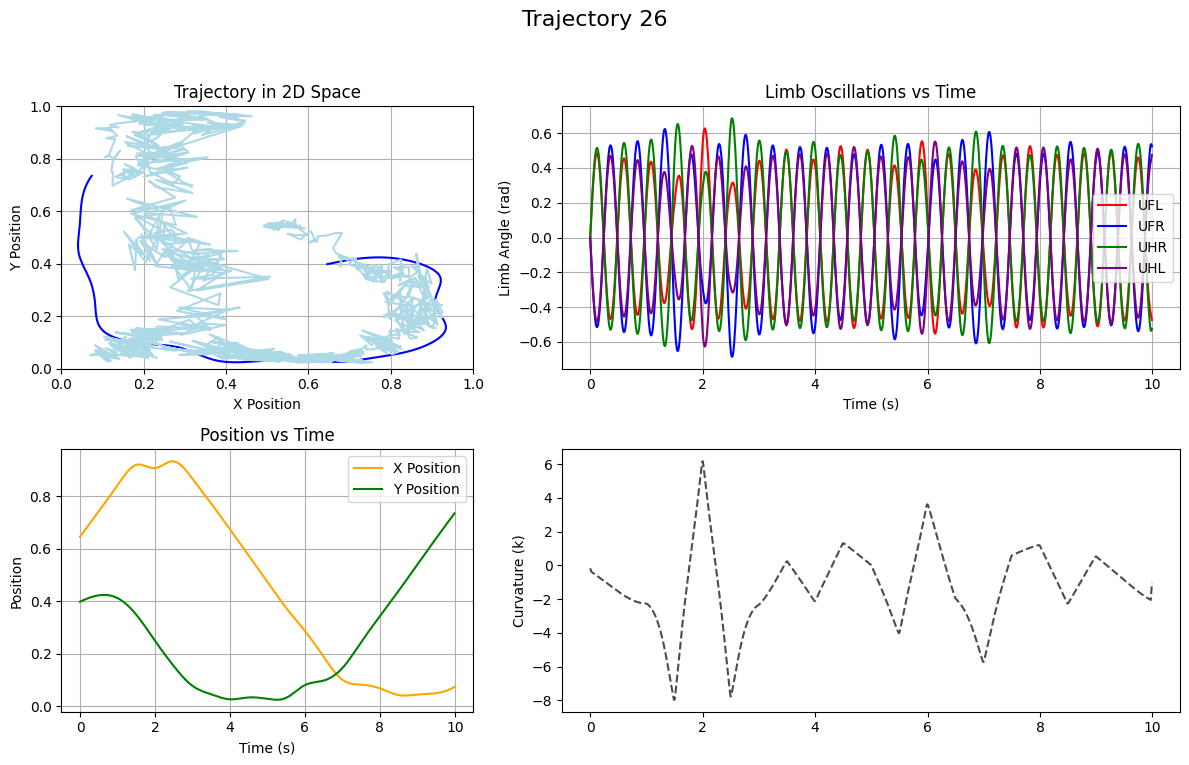

In [33]:
# Plotting trajectory, position vs time and limb oscillations for five random trajectories
for i in range(5):
    traj_index = np.random.randint(0, 100)
    X_traj = x_smooth_all[traj_index]
    Y_traj = y_smooth_all[traj_index]
    limb_data_traj = limb_data_all[traj_index]
    UFL, UFR, UHR, UHL, k = limb_data_traj

    # Time vector
    t = time_series[:len(X_traj)]

    # Create a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5]})
    fig.suptitle(f"Trajectory {traj_index+1}", fontsize=16)

    # --- Top-left: Trajectory in grid ---
    axes[0, 0].plot(X_traj, Y_traj, color='blue')
    axes[0, 0].plot(pos_pred[traj_index, :, 0], pos_pred[traj_index, :, 1], color='lightblue')
    axes[0, 0].set_title('Trajectory in 2D Space')
    axes[0, 0].set_xlabel('X Position')
    axes[0, 0].set_ylabel('Y Position')
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid()

    # --- Bottom-left: Position vs time ---
    axes[1, 0].plot(t, X_traj, label='X Position', color='orange')
    axes[1, 0].plot(t, Y_traj, label='Y Position', color='green')
    axes[1, 0].set_title('Position vs Time')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Position')
    axes[1, 0].legend()
    axes[1, 0].grid()

    # --- Right column (span): Limb oscillations ---
    ax_right = axes[0, 1]
    #axes[1, 1].remove()  # merge bottom cell with top
    ax_right.plot(t, UFL[:len(t)], label='UFL', color='red')
    ax_right.plot(t, UFR[:len(t)], label='UFR', color='blue')
    ax_right.plot(t, UHR[:len(t)], label='UHR', color='green')
    ax_right.plot(t, UHL[:len(t)], label='UHL', color='purple')
    ax_right.set_title('Limb Oscillations vs Time')
    ax_right.set_xlabel('Time (s)')
    ax_right.set_ylabel('Limb Angle (rad)')
    ax_right.legend()
    ax_right.grid()

    #Plotting k values
    ax_bottom_right = axes[1, 1]
    
    ax_bottom_right.plot(t, k[:len(t)], label='Curvature (k)', color='black', linestyle='--', alpha=0.7)
    ax_bottom_right.set_ylabel('Curvature (k)')
    #ax_k.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
